In [1]:
# inline plotting instead of popping out
%matplotlib inline

# python 3.7.3
import os

from IPython.display import Image
from IPython.display import display

# numpy  1.17.1
import numpy as np

# pandas  0.25.1
import pandas as pd

# scikit-learn  0.21.3
from scipy import interp
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import auc, confusion_matrix,  f1_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# cycler 0.10.0
from cycler import cycler

# matplotlib  3.1.1
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
plt = matplotlib.pyplot

# load utility classes/functions that has been taught in previous labs
# e.g., plot_decision_regions()
from lab04lib import *
import math

# Make output directory
if not os.path.exists("output/") : os.mkdir("output/")

In [2]:
#load the data
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                   'arrhythmia/arrhythmia.data', header=None, sep=',', engine='python')

display(data.head(3))

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10


In [3]:
print('%d rows and %d columns' % (data.shape[0],data.shape[1]))

452 rows and 280 columns


In [4]:
np.unique(data[len(data.columns)-1])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 14, 15, 16])

In [5]:
data['arrhythmia'] = data[len(data.columns)-1].map(lambda x: 0 if x==1 else 1)
data = data.drop(len(data.columns)-2, axis=1)

data.groupby(['arrhythmia']).size()

arrhythmia
0    245
1    207
dtype: int64

In [6]:
data = data._get_numeric_data()
print('%d rows and %d columns' % (data.shape[0],data.shape[1]))
data.head(3)

452 rows and 275 columns


,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,arrhythmia
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,1
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,1
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,1


In [7]:
X = data.iloc[:, :-1]  # The first to second-last columns are the features
y = data.iloc[:, -1]   # The last column is the ground-truth label
print(np.unique(y))
print(X.shape)

[0 1]
(452, 274)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20181004)

In [9]:
# Standardizing the training and test datasets
# Note that we are scaling based on the information from the training data
# Then we apply the scaling that is done from training data to the test data
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


In [10]:
class LogisticRegression(object):

    def __init__(self, eta=0.07, n_epoch=500, random_state=1):
        self.eta = eta
        self.n_epoch = n_epoch
        self.random_state = random_state
    
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_epoch):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            cost = self.loss(output, y)
            self.w_[1:] += (self.eta * X.T.dot(errors))# *(cost*2)
            self.w_[0] += self.eta * errors.sum()
#             cost = self.loss(output, y)
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
#         print(X.shape)
#         print(self.w_[1:].shape)
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def loss(self, output, y):
        """Calculate loss"""
        loss = np.mean((y-output)**2)
#         loss = np.max((output**y) + (1 - output)** (1 - y)) - np.mean((y-output)**2)
#         loss = np.sum((y * np.log(output)) + ((1 - y) * np.log(1 - output)))
#         print(loss)
        return loss
    
    def activation(self, z):
        """Compute logistic sigmoid activation"""
        act = (1 / (1 + np.exp(-z)))
        act = np.where(act > 0, 1, 0)
        return act

    def predict(self, X):
        """Return class label after unit step"""
        pred_prob = self.net_input(X)
        pred = self.activation(pred_prob)
        return pred
    
    def predict_proba(self, X):
        """Return probability of predict result after unit step"""
        pred_prob = self.net_input(X)
        return pred_prob

In [11]:
# Test with LogisticRegression from sklearn

# from sklearn.linear_model  import LogisticRegression as LR
# lr = LR()
# lr.fit(X_train_std, y_train)

# print(X_train.shape)
# print(X_test.shape)

# train_pred = lr.predict(X_train_std)
# train_pred_prob = lr.predict_proba(X_train_std)
# test_pred = lr.predict(X_test_std)
# # print("train_pred", train_pred)
# # print("train_pred_prob", train_pred_prob)
# from sklearn.metrics import mean_squared_error
# print('MSE train: %.2f, valid: %.2f' % (mean_squared_error(y_train, train_pred),mean_squared_error(y_test, test_pred)))
# from sklearn.metrics import accuracy_score
# print('Train Accuracy : %.2f' % accuracy_score(y_train, train_pred))
# print('Test Accuracy : %.2f' % accuracy_score(y_test, test_pred))

# weights, params = [], []
# for c in np.arange(-5, 5, dtype='float32'):
#     lr = LR(C = 10**c, random_state = 0, solver = "liblinear")
#     lr.fit(X_train_std, y_train)
#     # get the coefficients of w
#     weights.append(lr.coef_[0])
#     params.append(10**c)

# fig, ax = plt.subplots(figsize=(8,6))
# weights = np.array(weights)
# for i in range(274):
#     plt.plot(params, weights[:, i],
#              label='Petal length')

# plt.xlim(10**4, 10**-5)
# plt.xscale('log')
# plt.xlabel('C')
# plt.ylabel('Weight coefficient')
# # plt.legend(loc='upper right')
# plt.tight_layout()
# plt.legend(loc=1, prop={'size': 20})
# for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
#              ax.get_xticklabels() + ax.get_yticklabels()):
#     item.set_fontsize(20)
# for item in (ax.get_xticklabels() + ax.get_yticklabels()):
#     item.set_fontsize(15)
# plt.savefig('./output/fig-logistic-regression-c.png', dpi=300)
# plt.show()


In [12]:

lr = LogisticRegression()
lr.fit(X_train_std, y_train)

train_pred = lr.predict(X_train_std)
test_pred = lr.predict(X_test_std)

from sklearn.metrics import mean_squared_error
print('MSE train: %.2f, valid: %.2f' % (mean_squared_error(y_train, train_pred),mean_squared_error(y_test, test_pred)))
from sklearn.metrics import accuracy_score
print('Train Accuracy : %.2f' % accuracy_score(y_train, train_pred))
print('Test Accuracy : %.2f' % accuracy_score(y_test, test_pred))


/home/hhliao/.local/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp


MSE train: 0.04, valid: 0.25
Train Accuracy : 0.96
Test Accuracy : 0.75


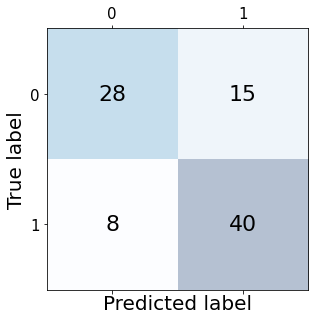


[F1-score]
Binary: 0.78


In [13]:


# plot confusion matrix

confmat = confusion_matrix(y_true=y_test, y_pred=test_pred)
fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.savefig('./output/fig-logistic-regression-confusion-3.png', dpi=300)
plt.show()

# # metrics

# print('[Precision]')
# p = precision_score(y_true=y_test, y_pred=test_pred, average=None)
# print('Individual: %.2f, %.2f' % (p[0], p[1]))
# p = precision_score(y_true=y_test, y_pred=test_pred, average='micro')
# print('Micro: %.2f' % p)
# p = precision_score(y_true=y_test, y_pred=test_pred, average='macro')
# print('Macro: %.2f' % p)

# print('\n[Recall]')
# r = recall_score(y_true=y_test, y_pred=test_pred,average=None)
# print('Individual: %.2f, %.2f' % (r[0], r[1]))
# r = recall_score(y_true=y_test, y_pred=test_pred, average='micro')
# print('Micro: %.2f' % r)
# r = recall_score(y_true=y_test, y_pred=test_pred, average='macro')
# print('Macro: %.2f' % r)


print('\n[F1-score]')
# f = f1_score(y_true=y_test, y_pred=test_pred, average=None)
# print('Individual: %.2f, %.2f' % (f[0], f[1]))
# f = f1_score(y_true=y_test, y_pred=test_pred, average='micro')
# print('Micro: %.2f' % f)
# f = f1_score(y_true=y_test, y_pred=test_pred, average='macro')
# print('Macro: %.2f' % f)
f = f1_score(y_true=y_test, y_pred=test_pred, average='binary')
print('Binary: %.2f' % f)

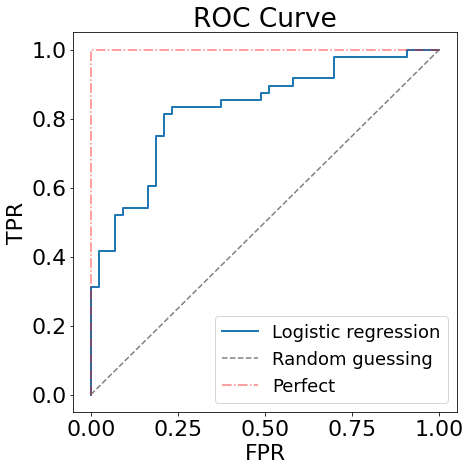

AUC: 0.83


In [14]:
fig = plt.figure(figsize=(7,7))

# mean_tpr = 0.0
# mean_fpr = np.linspace(0, 1, 100)
# all_tpr = []

probas = lr.predict_proba(X_test_std) 

# feature 0 as positive label
fpr, tpr, thresholds = roc_curve(y_test,
                                 probas[:],
                                 pos_label=1)

plt.plot(fpr, tpr, lw=2,
         label='Logistic regression')
    
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color='gray',
         label='Random guessing')

plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle='-.',
         alpha=0.5,
         color='red',
         label='Perfect')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.legend(loc=4, prop={'size': 18})
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.savefig('./output/fig-roc-lg.png', dpi=300)
plt.show()
print('AUC: %.2f' % auc(fpr, tpr))